This notebook does some simple plotting of `cosz` against upwards and downwards SW fluxes. A linear coefficient `beta` is extracted between `cosz` and `fnet_dn_sw_h` at the top level (index=-1). This coefficient is then used to scale both `fnet_dn_sw_h` and `fnet_up_sw_h` in `preprocessing_sw_dynamical.py` and `preprocessing_sw_optical.py`.

In [2]:
import os
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt

sys.path.append("/home/ucaptp0/oasis-rt-surrogate/model")
from model.rnn_sw.preprocessing_sw_dynamical import DataProcesser

ModuleNotFoundError: No module named 'model'

In [7]:
directory = "/home/ucaptp0/oasis-rt-surrogate/data/raw_data/raw_data"
timestep = 11
datapath = os.path.join(directory, "oasis_output_Venus_{}.h5".format(timestep))

# Load data
output = DataProcesser.extract_data(datapath)

## Short-wave Schema

In [15]:
# Extract cosz and sw fluxes
cosz = output["cosz"]
fnet_dn_sw_h = output["fnet_dn_sw_h"]
fnet_up_sw_h = output["fnet_up_sw_h"]

print("Shape of cosz: ", cosz.shape)
print("Shape of fnet_dn_sw_h: ", fnet_dn_sw_h.shape)
print("Shape of fnet_up_sw_h: ", fnet_up_sw_h.shape)

# Reshape flux data to cols x levels
ncol = 10242
nlev = 50
fnet_dn_sw_h = np.reshape(fnet_dn_sw_h, newshape=(ncol, nlev))
fnet_up_sw_h = np.reshape(fnet_up_sw_h, newshape=(ncol, nlev))

print("Shape of cosz: ", cosz.shape)
print("Shape of fnet_dn_sw_h: ", fnet_dn_sw_h.shape)
print("Shape of fnet_up_sw_h: ", fnet_up_sw_h.shape)

# Extract top layer fluxes
fnet_dn_sw_h_top = fnet_dn_sw_h[:, -1]
fnet_up_sw_h_top = fnet_up_sw_h[:, -1]

print("Shape of cosz: ", cosz.shape)
print("Shape of fnet_dn_sw_h_top: ", fnet_dn_sw_h_top.shape)
print("Shape of fnet_up_sw_h_top: ", fnet_up_sw_h_top.shape)

Shape of cosz:  (10242,)
Shape of fnet_dn_sw_h:  (512100,)
Shape of fnet_up_sw_h:  (512100,)
Shape of cosz:  (10242,)
Shape of fnet_dn_sw_h:  (10242, 50)
Shape of fnet_up_sw_h:  (10242, 50)
Shape of cosz:  (10242,)
Shape of fnet_dn_sw_h_top:  (10242,)
Shape of fnet_up_sw_h_top:  (10242,)


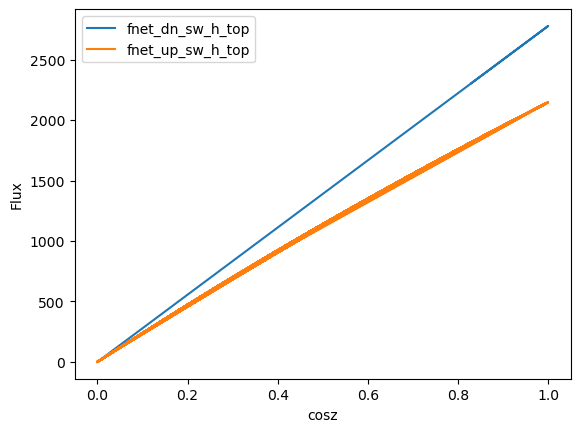

Coefficients of fit:  [2.77880599e+03 2.87579395e-13]


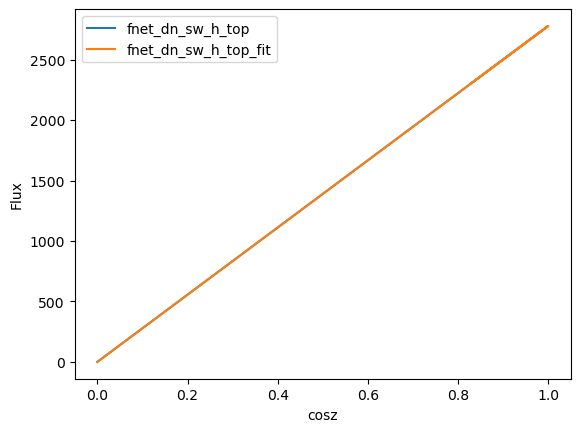

In [66]:
# Plot cosz vs. top layer fluxes
plt.figure()
plt.plot(cosz, fnet_dn_sw_h_top, label="fnet_dn_sw_h_top")
plt.plot(cosz, fnet_up_sw_h_top, label="fnet_up_sw_h_top")
plt.xlabel("cosz")
plt.ylabel("Flux")
plt.legend()
plt.show()

# Fit a straight line to cosz vs fnet_dn_sw_h_top with no intercept
coeffs = np.polyfit(cosz, fnet_dn_sw_h_top, 1)
print("Coefficients of fit: ", coeffs)
fnet_dn_sw_h_top_fit = coeffs[0] * cosz
plt.figure()
plt.plot(cosz, fnet_dn_sw_h_top, label="fnet_dn_sw_h_top")
plt.plot(cosz, fnet_dn_sw_h_top_fit, label="fnet_dn_sw_h_top_fit")
plt.xlabel("cosz")
plt.ylabel("Flux")
plt.legend()
plt.show()

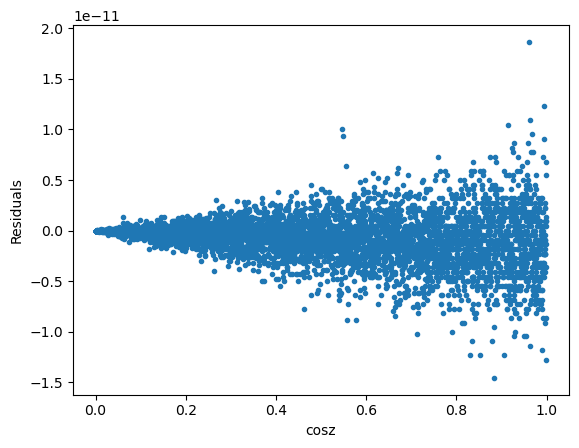

In [70]:
# Find the residuals as a scatter plot
residuals = fnet_dn_sw_h_top - fnet_dn_sw_h_top_fit
plt.figure()
plt.scatter(cosz, residuals, marker=".")
plt.xlabel("cosz")
plt.ylabel("Residuals")
plt.show()

In [76]:
beta = coeffs[0]

def scaling(cosz, flux_up, flux_down, beta):
    """
    Array shapes:
        cosz: (ncol,)
        flux_up: (ncol, nlev)
        flux_down: (ncol, nlev)
    """
    # Find indices where cosz==0
    idx = np.where(cosz == 0)
    
    # Remove columns from flux_up and flux_down where cosz==0
    flux_up = np.delete(flux_up, idx, axis=0)
    flux_down = np.delete(flux_down, idx, axis=0)
    cosz = np.delete(cosz, idx, axis=0)

    # Divide each column in flux_up by the corresponding cosz
    flux_up_scaled = flux_up / (beta * cosz[:, None])
    flux_down_scaled = flux_down / (beta * cosz[:, None])

    return cosz, flux_up_scaled, flux_down_scaled

cosz, fnet_up_sw_h_scaled, fnet_dn_sw_h_scaled = scaling(cosz, fnet_up_sw_h, fnet_dn_sw_h, beta)

print("Shape of fnet_up_sw_h_scaled: ", fnet_up_sw_h_scaled.shape)
print("Shape of fnet_dn_sw_h_scaled: ", fnet_dn_sw_h_scaled.shape)

Shape of fnet_up_sw_h_scaled:  (5120, 50)
Shape of fnet_dn_sw_h_scaled:  (5120, 50)


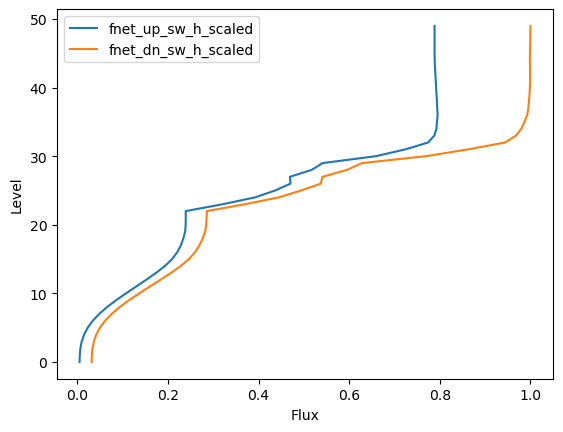

In [77]:
# For a given column, plot the scaled fluxes against the level
col = 0
plt.figure()
plt.plot(fnet_up_sw_h_scaled[col, :], range(nlev), label="fnet_up_sw_h_scaled")
plt.plot(fnet_dn_sw_h_scaled[col, :], range(nlev), label="fnet_dn_sw_h_scaled")
plt.xlabel("Flux")
plt.ylabel("Level")
plt.legend()
plt.show()

## Long-wave Schema

In [78]:
# Extract flx_grd and sw fluxes
flx_grd = output["flx_grd"]
fnet_dn_lw_h = output["fnet_dn_lw_h"]
fnet_up_lw_h = output["fnet_up_lw_h"]

print("Shape of flx_grd: ", flx_grd.shape)
print("Shape of fnet_dn_lw_h: ", fnet_dn_lw_h.shape)
print("Shape of fnet_up_lw_h: ", fnet_up_lw_h.shape)

# Reshape flux data to cols x levels
ncol = 10242
nlev = 50
fnet_dn_lw_h = np.reshape(fnet_dn_lw_h, newshape=(ncol, nlev))
fnet_up_lw_h = np.reshape(fnet_up_lw_h, newshape=(ncol, nlev))

print("Shape of flx_grd: ", flx_grd.shape)
print("Shape of fnet_dn_lw_h: ", fnet_dn_lw_h.shape)
print("Shape of fnet_up_lw_h: ", fnet_up_lw_h.shape)

# Extract top layer fluxes
fnet_dn_lw_h_top = fnet_dn_lw_h[:, -1]
fnet_up_lw_h_top = fnet_up_lw_h[:, -1]

print("Shape of flx_grd: ", flx_grd.shape)
print("Shape of fnet_dn_lw_h_top: ", fnet_dn_lw_h_top.shape)
print("Shape of fnet_up_lw_h_top: ", fnet_up_lw_h_top.shape)

Shape of flx_grd:  (10242,)
Shape of fnet_dn_lw_h:  (512100,)
Shape of fnet_up_lw_h:  (512100,)
Shape of flx_grd:  (10242,)
Shape of fnet_dn_lw_h:  (10242, 50)
Shape of fnet_up_lw_h:  (10242, 50)
Shape of flx_grd:  (10242,)
Shape of fnet_dn_lw_h_top:  (10242,)
Shape of fnet_up_lw_h_top:  (10242,)


In [1]:
# Plot flx_grd vs. top layer fluxes
plt.figure()
plt.plot(flx_grd, fnet_dn_lw_h_top, label="fnet_dn_lw_h_top")
plt.plot(flx_grd, fnet_up_lw_h_top, label="fnet_up_lw_h_top")
plt.xlabel("flx_grd")
plt.ylabel("Flux")
plt.legend()
plt.show()

# Fit a straight line to flx_grd vs fnet_dn_lw_h_top with no intercept
coeffs = np.polyfit(flx_grd, fnet_up_lw_h_top, 1)
print("Coefficients of fit: ", coeffs)
fnet_up_lw_h_top_fit = coeffs[0] * flx_grd
plt.figure()
plt.plot(flx_grd, fnet_up_lw_h_top, label="fnet_dn_lw_h_top")
plt.plot(flx_grd, fnet_up_lw_h_top_fit, label="fnet_dn_lw_h_top_fit")
plt.xlabel("flx_grd")
plt.ylabel("Flux")
plt.legend()
plt.show()

NameError: name 'plt' is not defined